# Outline
## 1) Introducing python packages for music segmentation (non-deep learning): Librosa, MSAF, pychorus 
## 2) Using segmented music to cut and edit music

In [1]:

# python modules
import pandas as pd
import numpy as np
from music21 import converter, chord, note, instrument, stream
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


#librosa and msaf
import librosa
from librosa.display import specshow
from collections import defaultdict
import msaf


#pychorus
import pychorus
from pychorus import find_and_output_chorus
from pychorus import create_chroma
from pychorus.similarity_matrix import TimeTimeSimilarityMatrix, TimeLagSimilarityMatrix

#other
plt.style.use('ggplot')
%pylab inline
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 999)


Populating the interactive namespace from numpy and matplotlib


# 1) Music Segmentation: Librosa

#### Librosa finds specific number of musical clusters. But it can't generate labels for these clusters, as far as I know.

In [68]:
def show_matrix(link):
    y, sr = librosa.load(link)
    decomposed = librosa.feature.mfcc(y = y, sr = sr)
    decomposed_r = librosa.segment.recurrence_matrix(decomposed)
    
    bounds = librosa.segment.agglomerative(decomposed, 6)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    bound_times
    duration = librosa.get_duration(y = y, sr = sr)


    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(decomposed_r, interpolation='nearest', cmap = cm.magma_r)
    title('Music Self Similarity Matrix');


    return bound_times, duration 

[  0.           5.7353288   38.52190476 141.73460317 178.93297052
 242.04480726]
duration: 259.63102040816324


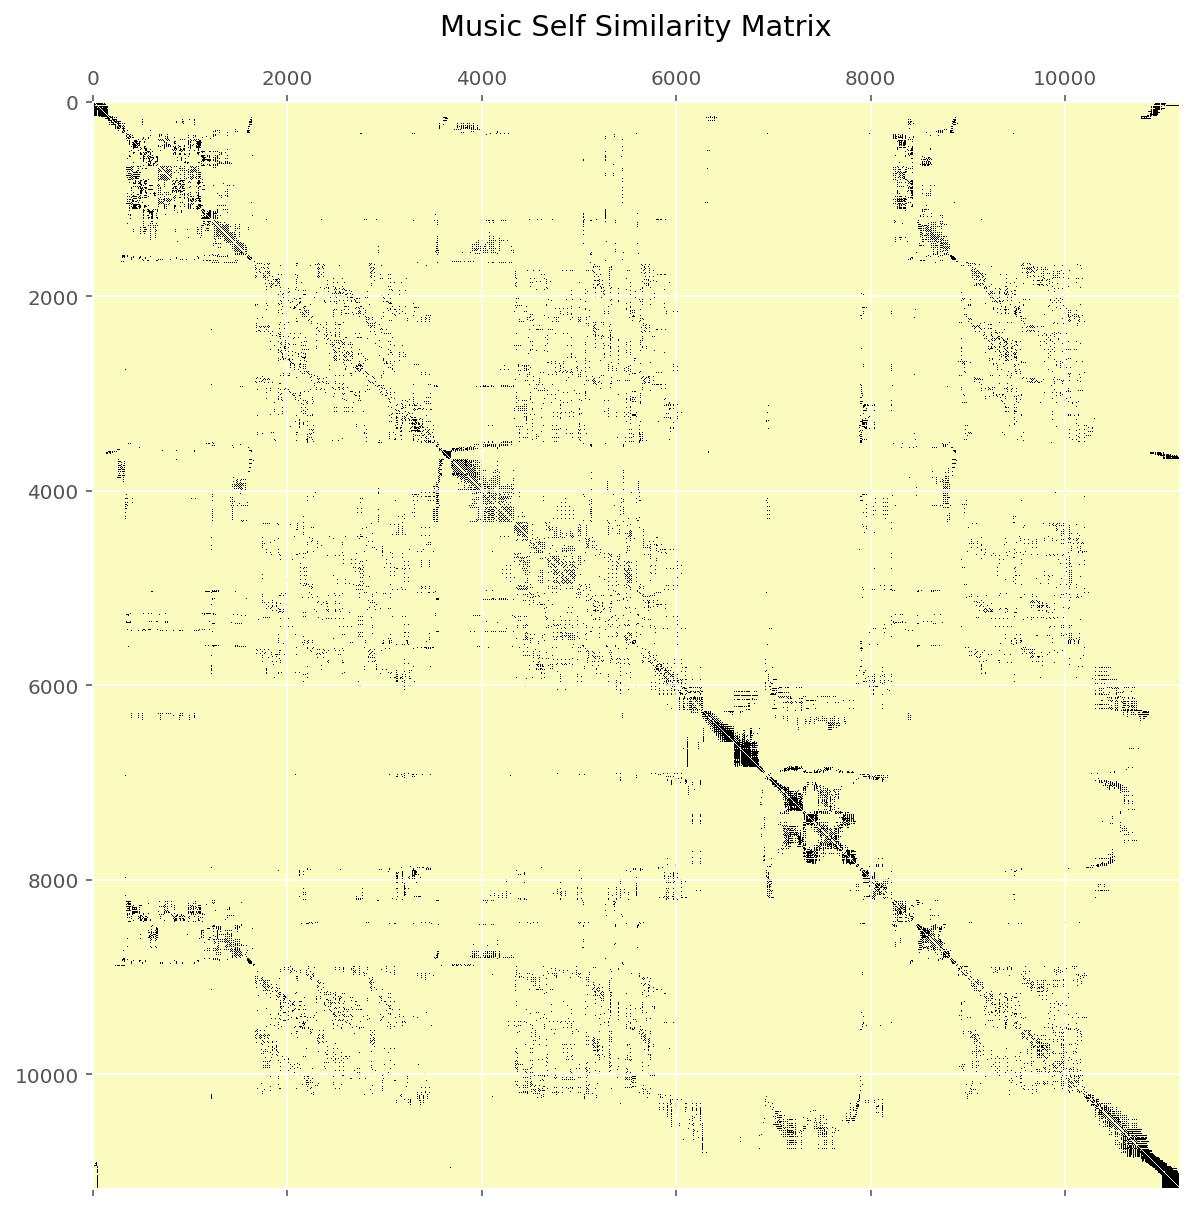

In [69]:
bound_times, duration = show_matrix('sampleEDM.mp3')
print(bound_times)
print('duration:', duration)

# MSAF

### MSAF generates labels for musical clusters, but you can't control the number of musical clusters / boundaries as far as I know. The labels aren't that accurate either

In [25]:
audiofile = 'sampleEDM.mp3'

print('boundary algorithms: {}'.format(msaf.get_all_boundary_algorithms()))
print('')
print('label algorithms: {}'.format(msaf.get_all_label_algorithms()))

boundary algorithms: ['olda', 'cnmf', 'example', 'sf', 'scluster', 'foote', 'vmo']

label algorithms: ['cnmf', 'fmc2d', 'scluster', 'vmo']


In [23]:
bounds, labels = msaf.process(audiofile, boundaries_id="foote", labels_id="fmc2d")

In [29]:
print("boundaries: {}".format(bounds))
print("labels: {}".format(labels))

boundaries: [  0.           3.90095238  38.12716553  69.52054422  82.430839
 103.51455782 134.44353741 153.11238095 190.68226757 205.26439909
 259.59909297 259.63102041]
labels: [4.0, 0.0, 3.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 2.0, 4.0]


# Pychorus

#### Pychorus is a small package that only does matrix representations, but this one is unique in giving us a heatmap 

In [30]:
chroma, _, sr, _ = create_chroma("sampleEDM.mp3")

In [31]:
time_time_similarity = TimeTimeSimilarityMatrix(chroma, sr)
time_lag_similarity = TimeLagSimilarityMatrix(chroma, sr)

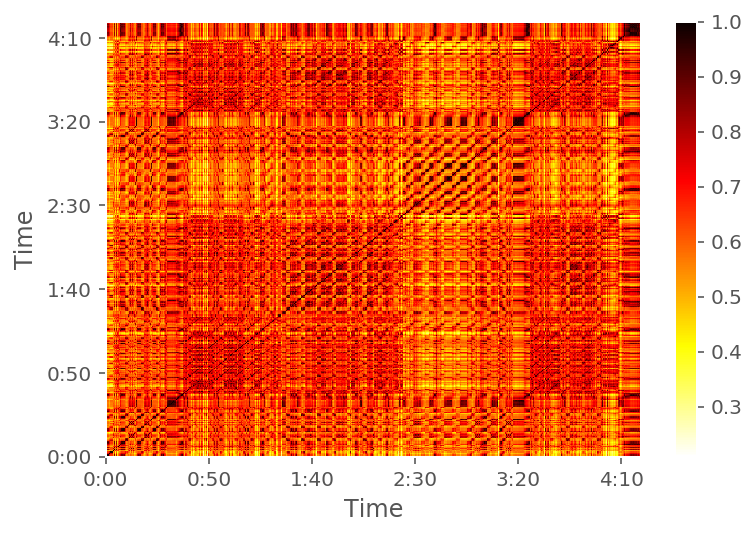

In [32]:
time_time_similarity.display()

# 2) Cutting and Editing Music

In [8]:
from pydub import AudioSegment

In [72]:
audio = AudioSegment.from_mp3("sampleEDM.mp3")

In [73]:
audio

In [158]:
def rearrange_music(link):
    
    # load and preprocess music 
    
    y, sr = librosa.load(link)
    decomposed = librosa.feature.mfcc(y = y, sr = sr)
    decomposed_r = librosa.segment.recurrence_matrix(decomposed)    
    bounds = librosa.segment.agglomerative(decomposed, 6)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    duration = librosa.get_duration(y = y, sr = sr)
    
    audio = AudioSegment.from_mp3(link)
    
    # normalize the boundary times, as the length given by pydub and length given by librosa is different
    
    bound_times_normalized = [((len(audio) * i) / duration) for i in bound_times ]
    
    
    # store segment number as the key and that segment itself as the value in a dictionary
    segment_dic = {}
    
    for i,j in enumerate(bound_times_normalized):
        if i < len(bound_times_normalized) -1:
            segment_dic[i] = audio[bound_times_normalized[i]: bound_times_normalized[i + 1]]

            
    # (Re)arrange the music by user preference. You can easily duplicate each segment too.
    arrangement = input('(Re)arrange the 5 different segments of the song by user preference: ex: 0,2,1,3,4,5,1,3,2 or 1,1,1  (from 0 to 4)   ')

    arrangement = [int(i) for i in arrangement.split(',')]
    
    
    
    rearranged = audio[:0]

    for i in arrangement:
        rearranged += segment_dic[i]
        
    return rearranged
    

In [160]:
rearranged = rearrange_music('sampleEDM.mp3')

rearranged

In [161]:
rearranged.export('newsong.mp3', format = 'mp3')

<_io.BufferedRandom name='newsong.mp3'>